# Energies for a symmetric mixture

In this document we compare the excess energies calculated by SAC equations and with the UNIQUAC model as suggested by [Wu et al. (1998)](https://doi.org/10.1021/ie950503r).

The pairwise results are the same as reported the ones obtained from Monte Carlo simulations (MC) also indistinguishble from the [COSMOSPACE](http://doi.wiley.com/10.1002/aic.690481023) resutls.

We start by importing the necessary packages.

In [6]:
import math, os, sys
import matplotlib.pyplot as plt
import pandas as pd

parent_directory = os.path.dirname(os.path.abspath('.'))
sys.path.append(parent_directory)

from pysac import SAC, RGAS

### Compound definitions

For the symmetric case, we set both compounds as having an unitary area such that area fractions match molar fractions. Additionally, in order to compare the results with the cubic lattice system we need to set `Q_eff = 1/z`.

In [7]:
Q_1   = [1]
Q_2   = [1]

z = 6
Q_eff = 1/z

# The mixture area
Q = [Q_1, Q_2]

## Interaction energies

Here we study the case of a strongly non-ideal mixture, where the first compound (0-0) interaction is strongly attractive when compared to the others. We make the interaction energies temperature independent by evaluating them at a reference temperature `T0`.

In [8]:
T0 = 300
epsij = [[-0.65, -0.2], [-0.2, -0.1]]

class SymmetricStronglyNonIdeal(SAC):
    def __init__(self):
        super().__init__(Q_eff=Q_eff)

    def calc_u(self, T, i, j, m, n):
        return epsij[i][j] * RGAS * T0

# Create an instance of our class
sac = SymmetricStronglyNonIdeal()

# Set a temperature, we use the reference `T0` so we get the same
# results as in the original work.
T = T0
sac.set_compounds(Q)
sac.set_temperature(T)

### Excess properties

We can get the total internal and subtract the pure values to get excess quantity at equimolar composition:

In [9]:
x = [0.5, 0.5]
sac.set_composition(x)
sac.calc_ln_gamma()
ue = sac.get_energy()
for i in range(len(Q)):
    ue -= x[i] * sac.get_energy_pure(i)

print(f"ue/RT: {ue}")

ue/RT: 0.23958933371753952


### Excess properties

Here we calculate the excess Helmholtz and internal energy on multiple compositions.

Here we translate the pair contact interaction energies to UNIQUAC parameters as in [Wu et al. (1998)](https://doi.org/10.1021/ie950503r). This direct translation leads to poor results.

In the [ue_symmetric](./ue_symmetric.ipynb) notepad we adjust new UNIQUAC interaction energies and then much better results are found.

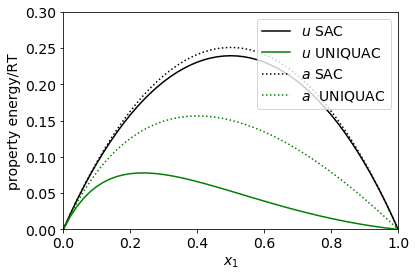

In [10]:
N = 51
ue_pw = []
ae_pw = []

ue_uniquac = []
ae_uniquac = []
x1 = []

for l in range(N):
    x1_ = l/(N-1)
    x1.append(x1_)

    x = [x1_, 1-x1_]
    
    sac.set_composition(x)
    sac.calc_ln_gamma()

    ae_pw_ = sac.get_helmholtz()
    ue_pw_ = sac.get_energy()

    ue_uniquac_ = 0.0
    ae_uniquac_ = 0.0

    sum_ni_qi = 0.0
    for i in range(len(x)):
        sum_xj_Pij = 0
        sum_xj_epsij_Pij = 0
        
        epsii = -math.log(sac.psi[i][i][0][0])

        for j in range(len(x)):
            epsij = -math.log(sac.psi[i][j][0][0])
            Pij = math.exp(-z/2*epsij)

            sum_xj_Pij += x[j] * Pij
            sum_xj_epsij_Pij += x[j] * epsij * Pij
            
        ue_uniquac_ += z/2 * sac.theta[i][0] * sum_xj_epsij_Pij / sum_xj_Pij
        ae_uniquac_ -= x[i] * math.log(sum_xj_Pij)

    # subtract the pure compound energies
    for i in range(len(x)):
        ue_pw_ -= x[i]*sac.get_energy_pure(i)
        ae_pw_ -= x[i]*sac.get_helmholtz_pure(i)
        ue_uniquac_ -= x[i]*sac.get_energy_pure(i)
        ae_uniquac_ -= x[i]*sac.get_helmholtz_pure(i)
    
    ae_pw.append(ae_pw_)
    ue_pw.append(ue_pw_)
    ue_uniquac.append(ue_uniquac_)
    ae_uniquac.append(ae_uniquac_)

plt.plot(x1, ue_pw, 'k-', label=r'$u$ SAC')
plt.plot(x1, ue_uniquac, 'g-', label=r'$u$ UNIQUAC')
plt.plot(x1, ae_pw, 'k:', label=r'$a$ SAC')
plt.plot(x1, ae_uniquac, 'g:', label=r'$a$  UNIQUAC')

plt.legend(loc='upper right')
plt.xlabel(r'$x_1$')
plt.ylabel(r'property energy/RT')
plt.xlim([0, 1])
plt.ylim([0, 0.3])

plt.rcParams.update({'font.size': 14})
plt.plot()
plt.savefig('pdf/ue-excess-direct.pdf')

As can be seen, UNIQUAC performs very poorly if the parameters are calculated directly from the pair contact interaction energies. However, if the UNIQUAC parameters are adjusted to match the Hemlholtz energy, then the excess energy becomes close to the pairwise model. This is explored on the [ue_symmetric](./ue_symmetric.ipynb) notebook.